<a href="https://colab.research.google.com/github/Gonkalos/AA2-Embeddings/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importes gerais / Instalações

In [ ]:
% matplotlib inline
!pip install kora
from IPython.display import clear_output 
clear_output()


import pandas as pd
import seaborn as sns
import numpy as np
import requests
import io
import os
import matplotlib.pyplot as plt

import kora.install.rdkit
from rdkit           import Chem
from rdkit.Chem      import AllChem
from rdkit.Chem      import Draw, Descriptors
from rdkit.Chem      import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn.model_selection import train_test_split

from keras           import regularizers
from keras.models    import Model
from keras.layers    import Input, LSTM, Dense, Concatenate 
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Get dataset from repository 
- Using original dataset instead of lastest review

In [ ]:
def get_data_From_GitHub(url, df):
    if url is None:
        url ='https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'
    df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')), index_col = 0)
    df.reset_index(inplace=True)
    return df

def process_smiles_array(smiles_array):
  lengths = list()
  for i in smiles_array:
      lengths.append(len(i))
  return lengths

def Cut_Range_of_Smiles(df,save,plot,smiles_lengths):
    if save is True:
        df['smiles_length'] = smiles_lengths
    plt.hist(smiles_lengths, bins=100)
    plt.ylabel('Number of SMILES')
    plt.xlabel('Length of SMILES')
    if plot is True:
        plt.show()
    return df

In [ ]:

df = get_data_From_GitHub(None,None)
smiles_lengths = process_smiles_array(df['smiles'].values)
df = Cut_Range_of_Smiles(df,True,True,smiles_lengths)


length_range = (0, 120) #Range of the cut
filtered = filter(lambda x: length_range[0] <= x <= length_range[1], smiles_lengths)
percentage = len(list(filtered)) / len(df['smiles'].values)
print('Percentage of instances with SMILES\' length between %s and %s: %s' % (length_range[0], length_range[1], percentage))

df = df[(df['smiles_length'] >= length_range[0]) & (df['smiles_length'] <= length_range[1])]
df = df.drop('smiles_length', axis='columns')
print(df.shape)

smiles_lengths = process_smiles_array(df['smiles'].values)
df = Cut_Range_of_Smiles(df,False,True,smiles_lengths)


# Seq2Seq Fingerprint
> informações utilizadas
> - https://github.com/XericZephyr/seq2seq-fingerprint/
> - https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/df.shape()

Seguimento do seguinte post: [**Master your molecule generator: Seq2seq RNN models with SMILES in Keras** ](https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/)

In [1]:
# General Imports
%matplotlib inline
data = df

smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)
print(df.fillna('').astype(str).apply(lambda x:x.str.len()).mean())

NameError: ignored

É necessário vectorizar os *SMILES* para um array.
para isto, um conjunto de caracteres é construido a partir de todos os caracteres encontrados nos *SMILES* (os de teste e de treino). 
Além disso, alguns caracteres são adicionaidos ao inicio e fim de cada *SMILE* para sinalizar quando a começou e acabou


*The stop character also work as padding to get the same length of all vectors, so that the network can be trained in batch mode. The character set is used to define two dictionaries to translate back and forth between index and character. The maximum length of the SMILES strings is needed as the RNN’s will be trained in batch mode, and is set to the maximum encountered + some extra.*

<!---The SMILES must be vectorized to one-hot encoded arrays. To do this a character set is built from all characters found in the SMILES string (both train and test). Also, some start and stop characters are added, which will be used to initiate the decoder and to signal when SMILES generation has stopped. The stop character also work as padding to get the same length of all vectors, so that the network can be trained in batch mode. The character set is used to define two dictionaries to translate back and forth between index and character. The maximum length of the SMILES strings is needed as the RNN’s will be trained in batch mode, and is set to the maximum encountered + some extra.-->

In [2]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

NameError: ignored

*Afterwards the character set and dictionaries are used to set the necessary bits in the Numpy arrays. The result will be a “piano-roll” of each molecules SMILES string. The X data starts with !, but the output Y is offset by one character, and starts with the first character of the actual SMILES.*


In [ ]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
print(X_train.shape)

In [ ]:
#The int_to_char dictionary can be used to go from vectorized form back to a readable string, here with a joined list comprehension.
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

Agora é o momento para construir o AutoEncoder, começando por calcular as dimenções dos vetores de treino e tambem o numero de LSTM cells para utilização do decoder e encoder

In [ ]:
#Import Keras objects
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 512
lstm_dim = 512

In [ ]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder        = LSTM(lstm_dim, return_state=True,unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [ ]:
decode_h        = Dense(lstm_dim, activation="relu")
decode_c        = Dense(lstm_dim, activation="relu")
state_h_decoded = decode_h(neck_outputs)
state_c_decoded = decode_c(neck_outputs)
encoder_states  = [state_h_decoded, state_c_decoded]
decoder_inputs  = Input(shape=input_shape)
decoder_lstm    = LSTM(lstm_dim,return_sequences=True,unroll=unroll)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense   = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print (model.summary())

In [ ]:
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam

In [ ]:
print(X_test.shape)
print(X_train.shape)
print(len([X_train,X_train]))
np.array(X_train).shape
#np.array(X_test[1]).shape()
#np.array(Y_test).shape()
#[X_test,X_test].shape()

In [ ]:
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = True, mode ='auto')
opt=Adam(lr=0.005) #Default 0.001 origem 0.005
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [ ]:
model.fit([X_train,X_train],Y_train,
                    epochs=300,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr, es],
                    validation_data=([X_test,X_test],Y_test))

# Nova secção

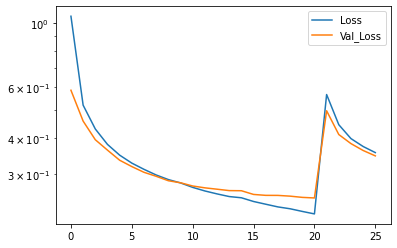

In [155]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [156]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)

O=C1Sc2ccccc2C(=O)N2CS(=O)CC12EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE C=C1CC2ccccc2C1=O)N1CCC=O)(C12EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CCOC(=O)NC(OCc1ccccc1)(C(=O)OC)C(F)(F)FEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(C(=O)CC(=)(1ccccc1)Cc)=O)cCCC(=)(F)FEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Nc1ncnc2c1ncn2C1OC(CO)(C(F)(F)F)C(O)C1OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE C#1cc(c2c1ncncc1CC(C))CCO=)(F)F)C(F)C(OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Cc1ccc(-c2n[nH]c(CC#N)n2)cc1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1ccc(Cc2ccnH]c3=)CN)ccCcc1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CCCCCC#C

In [157]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [158]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [159]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [160]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")
sample_model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(1, 1, 58)]              0         
_________________________________________________________________
lstm_23 (LSTM)               (1, 1, 512)               1169408   
_________________________________________________________________
dense_51 (Dense)             (1, 1, 58)                29754     
Total params: 1,199,162
Trainable params: 1,199,162
Non-trainable params: 0
_________________________________________________________________


In [161]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,22))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [162]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=400, callbacks = [rlr])


Epoch 1/400
238/238 [==============================] - 1s 2ms/step - loss: 281915.7561
Epoch 2/400
238/238 [==============================] - 1s 2ms/step - loss: 5.5319
Epoch 3/400
238/238 [==============================] - 1s 2ms/step - loss: 5.6858
Epoch 4/400
238/238 [==============================] - 1s 2ms/step - loss: 6.3176
Epoch 5/400
238/238 [==============================] - 1s 2ms/step - loss: 9.0341
Epoch 6/400
238/238 [==============================] - 1s 2ms/step - loss: 9.0993
Epoch 7/400
238/238 [==============================] - 1s 2ms/step - loss: 163.6475
Epoch 8/400
238/238 [==============================] - 1s 2ms/step - loss: 845.7269
Epoch 9/400
238/238 [==============================] - 1s 2ms/step - loss: 4168.6806
Epoch 10/400
238/238 [==============================] - 1s 2ms/step - loss: 20441.1214
Epoch 11/400
238/238 [==============================] - 1s 2ms/step - loss: 6.3468
Epoch 12/400
238/238 [==============================] - 1s 2ms/step - loss: 6.42

In [163]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

ValueError: ignored